In [238]:
import torch, math
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline

In [239]:
words = open('data/names.txt').read().splitlines()
words = list(set(w.lower() for w in words))
len(words)

21974

In [240]:
chars = sorted(list(set("".join(words))))
stoi = {s:i for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
vocab_size

29

In [241]:
block_size = 3

def build_dataset(words):
    X,Y = [], []
    context = [0]*block_size
    for w in words:
        for ch in w+'.':
            ix = stoi[ch]
            Y.append(ix)
            X.append(context)
            context = context[1:] + [ix]
    X,Y = torch.tensor(X), torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

In [242]:
import random

random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])

torch.Size([125900, 3]) torch.Size([125900])
torch.Size([15695, 3]) torch.Size([15695])
torch.Size([15685, 3]) torch.Size([15685])


In [253]:
def cmp(s, dt, t):
    exc = torch.all(dt==t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt-t.grad).abs().max().item()
    print(f"{s:15s} | exact {str(exc):5s} | abs {str(app):5s} | maxdiff {maxdiff:}")

In [254]:
n_emb = 10
n_hidden = 64

C = torch.randn((vocab_size, n_emb))

W1 = torch.randn((n_emb*block_size, n_hidden)) * (5/3)/((n_emb*block_size)**0.5)
b1 = torch.randn(n_hidden) * 0.1

bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

W2 = torch.randn((n_hidden, vocab_size)) * 0.1
b2 = torch.randn(vocab_size) * 0.1


parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

4287


In [255]:
batch_size = 32
n = batch_size
bix = torch.randint(0, Xtr.shape[0], (n,))
Xb,Yb = Xtr[bix], Ytr[bix]
Xb.shape, Yb.shape

(torch.Size([32, 3]), torch.Size([32]))

In [256]:
emb = C[Xb]
emb_cat = emb.view(emb.shape[0], -1)
hprebn = emb_cat @ W1 + b1

bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2

bnvar = 1/(n-1)*bndiff2.sum(0, keepdim=True)
bnvar_inv = (bnvar + 1e-5)**-0.5

bnraw = bndiff * bnvar_inv

hpreact = bngain * bnraw + bnbias

h = torch.tanh(hpreact)

logits = h @ W2 + b2

logits_max = logits.max(1, keepdim=True).values
logits_norm = logits - logits_max
counts = logits_norm.exp()
counts_sum = counts.sum(1, keepdim=True)
counts_sum_inv = counts_sum**-1
probs = counts*counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()


for p in parameters:
    p.grad = None
    
    
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv,
          logits_norm, logits_max, logits, h, hpreact, bnraw, bnvar,
          bnvar_inv, bndiff2, bndiff, hprebn, bnmeani,emb_cat, emb
         ]:
    t.retain_grad()
loss.backward()
loss

tensor(3.6158, grad_fn=<NegBackward0>)

In [292]:
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n

dprobs = (1.0/probs)*dlogprobs
dcounts_sum_inv = (counts*dprobs).sum(1, keepdim=True)
dcounts = counts_sum_inv*dprobs
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv

dcounts += torch.ones_like(counts)*dcounts_sum
dlogits_norm = counts*dcounts
dlogits = dlogits_norm.clone()
dlogits_max = (-dlogits_norm).sum(1, keepdim=True)
dlogits += F.one_hot(logits.max(1).indices,  num_classes=logits.shape[1]) * dlogits_max

dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)

dhpreact = (1.0-h**2)*dh
dbngain = (bnraw*dhpreact).sum(0, keepdim=True)
dbnraw = bngain*dhpreact

dbnbias = dhpreact.sum(0, keepdim=True)
dbndiff = bnvar_inv * dbnraw


dbnvar_inv = (bndiff*dbnraw).sum(0, keepdim=True)
dbnvar = -0.5*((bnvar+1e-5)**-1.5) * dbnvar_inv

dbndiff2 = (1.0/(n-1)) * (torch.ones_like(bndiff2) * dbnvar)
dbndiff += 2*(bndiff)* dbndiff2

dhprebn = dbndiff.clone()

dbnmeani =(-dbndiff).sum(0)

dhprebn += 1/n * (torch.ones_like(hprebn)*dbnmeani)
demb_cat = dhprebn @ W1.T
dW1 = emb_cat.T @ dhprebn
db1 = dhprebn.sum(0)
demb = demb_cat.view(emb.shape)

dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k, j]
        dC[ix] += demb[k,j]
        
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('count_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts', dcounts, counts)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('logits_norm', dlogits_norm, logits_norm)
cmp('logits', dlogits, logits)
cmp('logits_max', dlogits_max, logits_max)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw',dbnraw, bnraw)
cmp('bndiff', dbndiff, bndiff)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('hprebn', dhprebn, hprebn)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('embcat', demb_cat, emb_cat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact True  | abs True  | maxdiff 0.0
probs           | exact True  | abs True  | maxdiff 0.0
count_sum_inv   | exact True  | abs True  | maxdiff 0.0
counts          | exact True  | abs True  | maxdiff 0.0
counts_sum      | exact True  | abs True  | maxdiff 0.0
logits_norm     | exact True  | abs True  | maxdiff 0.0
logits          | exact True  | abs True  | maxdiff 0.0
logits_max      | exact True  | abs True  | maxdiff 0.0
h               | exact True  | abs True  | maxdiff 0.0
W2              | exact True  | abs True  | maxdiff 0.0
b2              | exact True  | abs True  | maxdiff 0.0
hpreact         | exact True  | abs True  | maxdiff 0.0
bngain          | exact True  | abs True  | maxdiff 0.0
bnbias          | exact True  | abs True  | maxdiff 0.0
bnraw           | exact True  | abs True  | maxdiff 0.0
bndiff          | exact True  | abs True  | maxdiff 0.0
bnvar_inv       | exact True  | abs True  | maxdiff 0.0
bnvar           | exact True  | abs True  | maxd

In [295]:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(),f"diff {(loss_fast - loss).item()}")

3.6158320903778076 diff -2.384185791015625e-07


In [300]:
dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n
cmp('logits', dlogits, logits)

logits          | exact False | abs False | maxdiff 0.1296791136264801


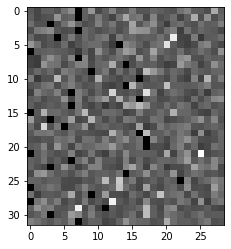

In [303]:
plt.imshow(dlogits.detach(), cmap='gray');

In [310]:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True))\
/ torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True)+1e-5) + bnbias

print('max diff', (hpreact_fast-hpreact).abs().max().item())

max diff 4.76837158203125e-07


In [311]:
dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
cmp('hprebh', dhprebn, hprebn)

hprebh          | exact False | abs True  | maxdiff 9.313225746154785e-10


In [317]:
n_emb = 10
n_hidden = 200

C = torch.randn((vocab_size, n_emb))

W1 = torch.randn((n_emb*block_size, n_hidden)) * (5/3)/((n_emb*block_size)**0.5)
b1 = torch.randn(n_hidden) * 0.1

bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.randn((1, n_hidden)) * 0.1

W2 = torch.randn((n_hidden, vocab_size)) * 0.1
b2 = torch.randn(vocab_size) * 0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.require_grad = True
    
    
n = batch_size
max_steps = 200000
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb,Yb = Xtr[ix], Ytr[ix]
    
    emb = C[Xb]
    emb_cat = emb.view(emb.shape[0], -1)
    
    hprebn = emb_cat @ W1 + b1
    
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b1
    loss = F.cross_entropy(logits, Yb)
    
    for p in parameters:
        p.grad = None
        
    
    
    
    break

12719
